In [2]:
import numpy as np
import statsmodels.api as sm
import time
from sklearn.linear_model import LogisticRegression
import scipy.stats as stat
import matplotlib.pyplot as plt

In [3]:
np.random.seed(2013)
n = 10000 # samples
m = 1000 # SNPs
k = 5 # num of covariates

S = np.random.normal(0, 1, size=(n, m)) # SNP matrix
X0 = np.random.uniform(0, 1, size=(n, k)) # covariates matrix 
ones = np.zeros(n) + 1
X = np.append(ones.reshape(n, 1), X0, axis=1)
y = np.random.binomial(1, 0.5, n).reshape(n,1)

# semi-parallel log regression with covariates

fit regression with const matrix(covariates are the same for each SNP for one person), then do 1 iteration of Newton-Rhapsod(NR) with SNP term in regression.

semi-parallel approach is realized in firstly doing one regression with covariates for all SNPs and then doing one iteration of NR for all SNP simultaneously(calculate S_star and not for each column of S separately)

In [5]:
t0 = time.time()
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
p = model.fittedvalues.reshape(n,1)

w = p * (1 - p) # diag matrix with const elem
z = np.log(p / (1 - p)) + (y - p) / (p * (1 - p))
xtw = (X * w).T # X^T * W
U1 = xtw @ z
U2 = np.linalg.solve(xtw @ X, U1) # find betta_t, needed to find z*
z_star = z - X @ U2
U4 = np.linalg.solve(xtw @ X, xtw @ S) 
S_star = S - X @ U4
Str2 = np.sum(w * S_star**2, axis = 0) # m size vector of sums(w_i * s_i^2)
beta = np.sum(z_star * w * S_star, axis=0) / Str2 # m size vect of sums(wi zi si) / str2
err = Str2**-0.5
pval = 2 * stat.norm.cdf(-np.abs(beta / err))

# # Report time
t1 = time.time() - t0
msip = 1e-06 * n * m / t1
print(f"Speed: {msip:.2f} Msips\n")

Speed: 16.74 Msips
 16.743180462755312


non semi-parallel approach - fit regression for each SNP separately

In [105]:
t0 = time.time()
beta_sep = np.zeros(m)
pval_sep = np.zeros(m)
err_sep = np.zeros(m)
for i in range(m):
    X_si = np.append(S[:,i].reshape(n,1), X, axis=1)
    model = sm.GLM(y, X_si, family=sm.families.Binomial()).fit()
    beta_sep[i] = model.params[0]
    pval_sep[i] = model.pvalues[0]
# # Report time
t1 = time.time() - t0
msip = 1e-06 * n * m / t1
print(f"Speed: {msip:.2f} Msips\n")

print(beta_sep)
print(pval_sep)    

# results.summary()


Speed: 0.3738863802600303 Msips
 0.3738863802600303
[ 4.91285382e-02 -2.95417587e-02  1.63043913e-02  8.51242927e-03
  1.15281596e-02 -1.05842181e-02  4.76845204e-03 -3.52108551e-02
  2.07387985e-02  9.62165985e-03  9.62422980e-03  4.90052151e-03
  2.33919356e-03 -7.29618857e-03 -1.39162089e-02  5.86912500e-03
  2.01149479e-02  1.44103990e-02 -2.36776420e-03  2.72030014e-03
  3.63493489e-02  5.80963997e-03 -1.04030098e-02 -1.03501074e-02
 -1.24087688e-03  2.73753254e-02 -3.85704454e-04 -1.24215329e-02
 -4.71711520e-04 -4.01922781e-02  6.75411968e-03  1.16000752e-02
  3.98557988e-02 -1.09989712e-02  4.13327902e-03  3.27118487e-02
  3.65015397e-02 -1.96646069e-02  1.42830681e-02 -1.37811640e-02
 -1.39112044e-02 -1.48966105e-02  2.16024952e-02 -3.72149226e-02
  2.54201343e-02 -1.65071049e-03 -1.48322386e-02  1.69430454e-02
  1.05292538e-02 -1.69628490e-02  1.07872068e-02 -1.04104724e-02
  2.92101101e-02 -7.46375294e-03 -1.45788084e-02 -4.71992594e-03
 -1.64588544e-02 -9.63021628e-04  3.31

(array([100.,  85.,  87.,  93., 114., 114., 105.,  92.,  97., 113.]),
 array([0.00103895, 0.10088459, 0.20073023, 0.30057586, 0.4004215 ,
        0.50026714, 0.60011278, 0.69995842, 0.79980406, 0.8996497 ,
        0.99949533]),
 <BarContainer object of 10 artists>)

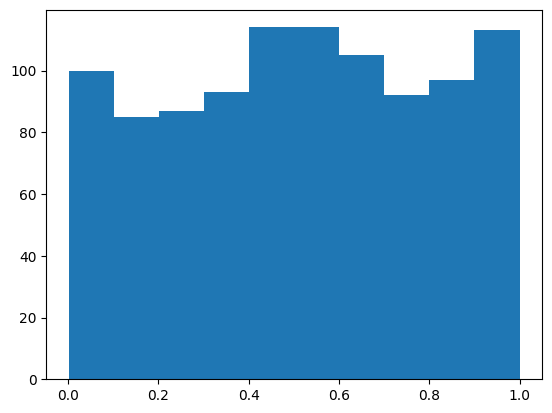

In [109]:
plt.hist(pval_sep)

(array([100.,  85.,  87.,  93., 114., 114., 105.,  92.,  97., 113.]),
 array([0.00103251, 0.1008788 , 0.20072508, 0.30057136, 0.40041764,
        0.50026392, 0.60011021, 0.69995649, 0.79980277, 0.89964905,
        0.99949533]),
 <BarContainer object of 10 artists>)

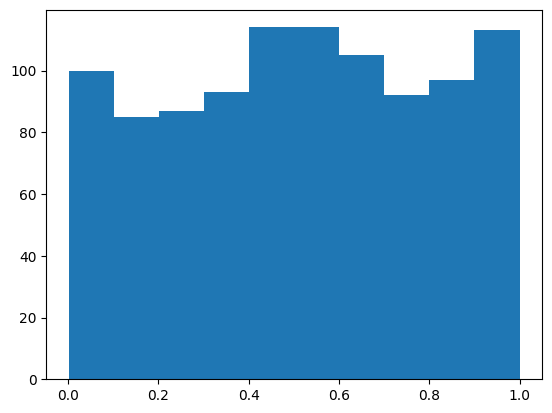

In [117]:
plt.hist(pval)

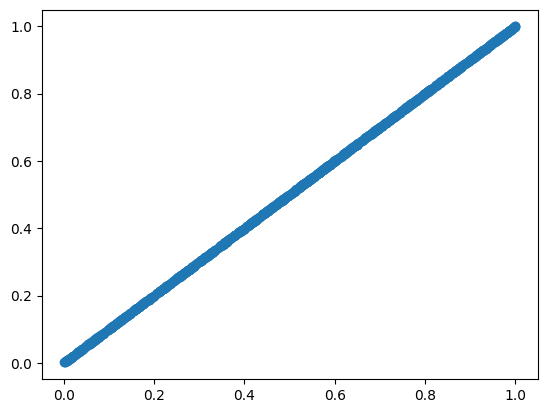

In [118]:
plt.plot(pval,pval_sep,'o')